<a href="https://colab.research.google.com/github/FangTzuLiang/Image-Process/blob/main/HW2_0914.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GRAD-CAM（Gradient-weighted Class Activation Mapping）:一種用於解釋CNN模型預測的視覺解釋技術

In [3]:
# 用keras建立model
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# 彩色影像reshape
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255
# to_categorical將目標變量進行One-Hot編碼，將類別轉為二進制
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Create a simple CNN model
model = Sequential()# 創建一個 Sequential 模型，用於堆疊神經網路層
# 添加一個2D卷積層，使用32個濾波器，每個濾波器大小為3x3，啟動函數為ReLU，輸入形狀為28x28x1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# 添加一個2D最大池化層，池化窗口大小為2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# 添加一個全局平均池化層，用於降低Feature Map維度。降維方法:Max Pooling、Autoencoder、Feature Selection...
model.add(GlobalAveragePooling2D())
# 添加一個全連接層，輸出維度為10，啟動函數為softmax
model.add(Dense(10, activation='softmax'))

# 編譯模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model (you can adjust epochs and batch size as needed)
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
469/469 [==============================] - 25s 52ms/step - loss: 2.2322 - accuracy: 0.1823 - val_loss: 2.1217 - val_accuracy: 0.2637
Epoch 2/10
469/469 [==============================] - 21s 44ms/step - loss: 2.0025 - accuracy: 0.3015 - val_loss: 1.8951 - val_accuracy: 0.3380
Epoch 3/10
469/469 [==============================] - 22s 48ms/step - loss: 1.8307 - accuracy: 0.3540 - val_loss: 1.7623 - val_accuracy: 0.3748
Epoch 4/10
469/469 [==============================] - 22s 48ms/step - loss: 1.7257 - accuracy: 0.3829 - val_loss: 1.6762 - val_accuracy: 0.4014
Epoch 5/10
469/469 [==============================] - 24s 52ms/step - loss: 1.6543 - accuracy: 0.4045 - val_loss: 1.6142 - val_accuracy: 0.4173
Epoch 6/10
469/469 [==============================] - 21s 44ms/step - loss: 1.6019 - accuracy: 0.4213 - val_loss: 1.5653 - val_accuracy: 0.4382
Epoch 7/10
469/469 [==============================] - 22s 48ms/step - l

In [4]:
# Define Grad-CAM function
def grad_cam(input_model, image):
    # 將輸入圖像擴展為4D張量，加到批次中，讓模型可以跑得更有效率
    x = np.expand_dims(image, axis=0)
    preds = input_model.predict(x)# 預測

    # Get the last convolutional layer
    last_conv_layer = input_model.get_layer('conv2d')
    # 創建一個新的模型last_conv_layer_model，只包括最後一個卷積層的輸出
    last_conv_layer_model = tf.keras.Model(input_model.inputs, last_conv_layer.output)

    # 創建一個分類器模型，用於後續計算梯度
    # 創建一個新的輸入層y，形狀與最後一個卷積層的輸出形狀相同
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    y = classifier_input
    # 將input_model的層添加到了y中
    for layer_name in ["global_average_pooling2d", "dense"]:
        y = model.get_layer(layer_name)(y)

    # 創建一個新的模型classifier_model，輸入為classifier_input，輸出為y
    # classifier_model是一個包含了原始model中指定的層的模型，用於進行分類操作
    # 這個新模型將被用於後續計算梯度和生成GRAD-CAM熱度圖
    classifier_model = tf.keras.Model(classifier_input, y)

    # 使用梯度帶（GradientTape）計算梯度
    with tf.GradientTape() as tape:
      inputs = image[np.newaxis, ...]
      last_conv_layer_output = last_conv_layer_model(inputs)

      # 設置梯度帶以監控最後卷積層的輸出
      tape.watch(last_conv_layer_output)

      # 使用分類器模型進行預測
      preds = classifier_model(last_conv_layer_output)
      # 獲取預測中的最高概率類別索引
      top_pred_index = tf.argmax(preds[0])
      # 獲取預測中的最高概率類別的分數
      top_class_channel = preds[:, top_pred_index]
      print(top_pred_index)

    # 計算相對於最後卷積層輸出的梯度
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # 將梯度平均以獲得池化後的梯度
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    # 轉為NumPy陣列
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    # 這個迴圈將對每個filters的相應區域進行梯度加權
    for i in range(pooled_grads.shape[-1]):
        # 乘以每個filters的池化梯度
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # Average over all the filters to get a single 2D array
    gradcam = np.mean(last_conv_layer_output, axis=-1)
    # Clip the values (equivalent to applying ReLU) and then normalise the values
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    # 調整大小以匹配原始圖像大小
    gradcam = cv2.resize(gradcam, (28, 28))
    return gradcam

In [5]:
model.summary()
grad_cam = grad_cam(model, X_test[0])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 650 (2.54 KB)
Trainable params: 650 (2.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [=====================

(28, 28, 1)


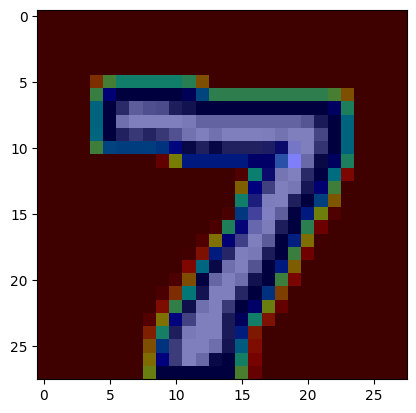

In [6]:
plt.imshow(X_test[0].squeeze(), cmap='gray')
print(X_test[0].shape)
plt.imshow(grad_cam, alpha=0.5, cmap='jet')